In [1]:
import os
import random
import pickle
import zipfile
import multiprocessing
import math
from functools import partial
from contextlib import contextmanager
from pathlib import Path
import glob
from filelock import FileLock
from itertools import chain

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, einsum

from einops import rearrange, repeat
from einops_exts import repeat_many
from einops.layers.torch import Rearrange

from memorizing_transformers_pytorch.knn_memory import KNNMemoryList, DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from tqdm.notebook import tqdm


#torch.set_default_dtype(torch.float32)

# helper functions

In [2]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [3]:
def identity(t):
    return t

def exists(val):
    return val is not None

def unique(arr):
    return list({el: True for el in arr}.keys())

def default(val, d):
    return val if exists(val) else d

def cast_tuple(val, length = 1):
    return val if isinstance(val, tuple) else ((val,) * length)

def l2norm(t):
    return F.normalize(t, dim = -1)

def stable_softmax(t, dim = -1):
    t = t - t.amax(dim = dim, keepdim = True).detach()
    return F.softmax(t, dim = dim)

# helper classes

In [4]:
def posemb_sincos_2d(patches, temperature = 10000, dtype = torch.float32):
    _, h, w, dim, device, dtype = *patches.shape, patches.device, patches.dtype

    y, x = torch.meshgrid(torch.arange(h, device = device), torch.arange(w, device = device), indexing = 'ij')
    assert (dim % 4) == 0, 'feature dimension must be multiple of 4 for sincos emb'
    omega = torch.arange(dim // 4, device = device) / (dim // 4 - 1)
    omega = 1. / (temperature ** omega)

    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :] 
    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos()), dim = 1)
    return pe.type(dtype)

In [5]:
class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, **kwargs):
        out = self.fn(self.norm(x), **kwargs)

        if not isinstance(out, tuple):
            return out + x

        head, *tail = out
        return (head + x, *tail)

# t5 relative positional bias

In [6]:
class T5RelativePositionBias(nn.Module):
    def __init__(
        self,
        scale,
        num_buckets = 32,
        max_distance = 128,
        heads = 8
    ):
        super().__init__()
        self.scale = scale
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.relative_attention_bias = nn.Embedding(num_buckets, heads)

    @staticmethod
    def _relative_position_bucket(
        relative_position,
        num_buckets = 32,
        max_distance = 128
    ):
        n = -relative_position
        n = torch.max(n, torch.zeros_like(n))

        max_exact = num_buckets // 2
        is_small = n < max_exact

        val_if_large = max_exact + (torch.log(n.float() / max_exact) / math.log(max_distance / max_exact) * (num_buckets - max_exact)).long()
        val_if_large = torch.min(val_if_large, torch.full_like(val_if_large, num_buckets - 1))
        return torch.where(is_small, n, val_if_large)

    def forward(self, i, j, *, device):
        q_pos = torch.arange(i, dtype = torch.long, device = device)
        k_pos = torch.arange(j, dtype = torch.long, device = device)
        rel_pos = rearrange(k_pos, 'j -> 1 j') - rearrange(q_pos, 'i -> i 1')
        rp_bucket = self._relative_position_bucket(rel_pos, num_buckets = self.num_buckets, max_distance = self.max_distance)
        values = self.relative_attention_bias(rp_bucket)
        bias = rearrange(values, 'i j h -> () h i j')
        return bias * self.scale

# feedforward

In [7]:
class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * mult),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

# Attention

In [8]:
class Attention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads = 8,
        dim_head = 64,
        dropout = 0.,
        xl_max_memories = 0.,
    ):
        super().__init__()
        
        inner_dim = heads * dim_head
        self.heads = heads
        self.scale = dim_head ** -0.5
        self.xl_max_memories = xl_max_memories

        self.norm = nn.LayerNorm(dim) #vit
        self.attend = nn.Softmax(dim = -1) #vit

        self.dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, dim_head * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, *, xl_memory = None, rel_pos_bias = None):
        
        x = self.norm(x)
        
        h, device = self.heads, x.device
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = -1))

        q = rearrange(q, 'b n (h d) -> b h n d', h = h)

        q = q * self.scale

        if exists(xl_memory):
            k_xl_mem, v_xl_mem = xl_memory.unbind(dim = -2)
            k = torch.cat((k_xl_mem, k), dim = -2)
            v = torch.cat((v_xl_mem, v), dim = -2)

        sim = einsum('b h i d, b j d -> b h i j', q, k)
        i, j = sim.shape[-2:]

        if exists(rel_pos_bias):
            sim = rel_pos_bias[..., -i:, -j:] + sim

        causal_mask = torch.ones((i, j), dtype = torch.bool, device = device).triu(j - i + 1)
        sim = sim.masked_fill(causal_mask, -torch.finfo(sim.dtype).max)

        attn = stable_softmax(sim)
        attn = self.dropout(attn)

        out = einsum('b h i j, b j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        # new xl memories

        new_kv_memories = torch.stack((k, v), dim = -2).detach()

        if self.xl_max_memories > 0:
            new_xl_kv_memories = new_kv_memories[:, -self.xl_max_memories:]
        else:
            new_xl_kv_memories = None

        return self.to_out(out), new_xl_kv_memories

# approximate nearest neighbor attention

In [9]:
class KNNAttention(nn.Module):
    def __init__(
        self,
        *,
        dim,
        heads = 8,
        dim_head = 64,
        dropout = 0.,
        num_retrieved_memories = 32,
        xl_max_memories = 0.,
        attn_scale_init = 20,
        gate_output = False
    ):
        super().__init__()
        self.heads = heads
        self.scale = nn.Parameter(torch.ones(heads, 1, 1) * math.log(attn_scale_init))

        inner_dim = heads * dim_head
        self.xl_max_memories = xl_max_memories

        self.num_retrieved_memories = num_retrieved_memories

        self.dropout = nn.Dropout(dropout)
        self.knn_mem_dropout = nn.Dropout(dropout)

        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, dim_head * 2, bias = False)
        self.to_out = nn.Linear(inner_dim, dim, bias = False)

        self.output_gate = nn.Parameter(torch.zeros(1)) if gate_output else None

    def forward(
        self,
        x,
        *,
        knn_memory,
        xl_memory = None,
        add_knn_memory = True,
        rel_pos_bias = None
    ):
        b, n, h, device = *x.shape[:2], self.heads, x.device
        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = -1))

        q = rearrange(q, 'b n (h d) -> b h n d', h = h)

        # in paper, they showed normalizing of keys led to more stable training
        # we'll just go with full cosine sim attention https://arxiv.org/abs/2010.04245

        q, k = map(l2norm, (q, k))

        # handle xl memory

        if exists(xl_memory):
            k_xl_mem, v_xl_mem = xl_memory.unbind(dim = -2)
            k = torch.cat((k_xl_mem, k), dim = -2)
            v = torch.cat((v_xl_mem, v), dim = -2)

        # calculate local attention

        scale = self.scale.exp()

        sim = einsum('b h i d, b j d -> b h i j', q, k) * scale
        i, j = sim.shape[-2:]

        if exists(rel_pos_bias):
            sim = rel_pos_bias[..., -i:, -j:] + sim

        mask_value = -torch.finfo(sim.dtype).max

        causal_mask = torch.ones((i, j), dtype = torch.bool, device = device).triu(j - i + 1)
        sim = sim.masked_fill(causal_mask, mask_value)

        # calculate knn attention over memory, if index is passed in

        mem_kv, mem_mask = knn_memory.search(q, self.num_retrieved_memories)
        mem_k, mem_v = mem_kv.unbind(dim = -2)

        sim_mem = einsum('b h i d, b h i j d -> b h i j', q, mem_k) * scale
        sim_mem = sim_mem.masked_fill(~mem_mask, mask_value)

        # calculate new XL memories, as well as memories to be discarded

        new_kv_memories = torch.stack((k, v), dim = -2).detach()

        if self.xl_max_memories > 0:
            new_kv_memories_discarded, new_xl_kv_memories = new_kv_memories[:, :-self.xl_max_memories], new_kv_memories[:, -self.xl_max_memories:]
        else:
            new_kv_memories_discarded, new_xl_kv_memories = new_kv_memories, None

        # add memories to be discarded into KNN memory

        if add_knn_memory and new_kv_memories_discarded.numel() > 0:
            knn_memory.add(new_kv_memories_discarded)

        # attention (combining local and distant)

        sim = torch.cat((sim_mem, sim), dim = -1)
        attn = stable_softmax(sim)
        attn = self.dropout(attn)

        local_attn, mem_attn = attn[..., self.num_retrieved_memories:], attn[..., :self.num_retrieved_memories]
        local_out = einsum('b h i j, b j d -> b h i d', local_attn, v)
        mem_out = einsum('b h i j, b h i j d -> b h i d', mem_attn, mem_v)

        out = local_out + mem_out

        # combine heads and project out

        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)

        # use flamingo styled gating of output, so that memorizing transformers can be gated into an existing LLM
        # preparation to add this to block-recurrent-transformer-pytorch, for the pinnacle of long context attention network

        if exists(self.output_gate):
            out = out * self.output_gate.tanh()

        return out, new_xl_kv_memories

# main class

In [10]:
class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )
        
        # self.to_patch_embedding = nn.Sequential(
        #     Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
        #     nn.LayerNorm(patch_dim),
        #     nn.Linear(patch_dim, dim),
        #     nn.LayerNorm(dim),
        # )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

In [11]:
class MemorizingSPTViT(nn.Module):
    def __init__(
        self,
        *,

        image_size,
        patch_size,
        num_classes,

        dim,
        depth,

        channels = 3,
        
        dim_head = 64,
        heads = 8,
        knn_attn_heads = None,
        attn_dropout = 0.,
        ff_mult = 4,
        ff_dropout = 0.,
        memorizing_layers = None,
        max_knn_memories = 250000,
        num_retrieved_memories = 32,
        clear_memories_on_sos_token_id = None,
        clear_memories_on_eos_token_id = None,
        knn_memories_directory = DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY,
        shift_knn_memories_down = 0.,
        xl_max_memories = 0,
        xl_memory_layers = None,
        shift_xl_memories_down = 0.,
        knn_memory_multiprocessing = False
    ):
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)
        
        # self.to_patch_embedding = nn.Sequential(
        #     Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1 = patch_height, p2 = patch_width),
        #     nn.LayerNorm(patch_dim),
        #     nn.Linear(patch_dim, dim),
        #     nn.LayerNorm(dim),
        # )

        block_wrapper = partial(PreNormResidual, dim)
        valid_layers = set(range(1, depth + 1))

        memorizing_layers = default(memorizing_layers, (depth // 2,)) # default KNN attention layer to midpoint of transformer
        memorizing_layers = cast_tuple(memorizing_layers)
        memorizing_layers = tuple(filter(lambda i: i in valid_layers, memorizing_layers))

        self.dim_head = dim_head

        knn_attn_heads = default(knn_attn_heads, heads)

        # xl memory hyperparameter

        if xl_max_memories > 0:
            xl_memory_layers = default(xl_memory_layers, tuple(range(1, depth + 1)))
            xl_memory_layers = unique(xl_memory_layers)
            self.xl_memory_layers = tuple(filter(lambda i: i in valid_layers, xl_memory_layers))            
            self.num_xl_memory_layers = len(self.xl_memory_layers)
        else:
            self.xl_memory_layers = tuple()
            self.num_xl_memory_layers = 0

        # knn memory hyperparameters

        self.max_knn_memories = max_knn_memories
        self.knn_memories_directory = knn_memories_directory
        self.memorizing_layers = unique(memorizing_layers)
        self.num_memory_layers = len(memorizing_layers)

        self.clear_memories_on_sos_token_id = clear_memories_on_sos_token_id
        self.clear_memories_on_eos_token_id = clear_memories_on_eos_token_id

        # relative positional bias

        self.rel_pos_bias = T5RelativePositionBias(scale = dim_head ** 0.5, heads = heads)
        self.knn_rel_pos_bias = T5RelativePositionBias(scale = dim_head ** 0.5, heads = heads)

        # layers

        self.layers = nn.ModuleList([])
        for idx in range(depth):
            layer_num = idx + 1

            use_xl_memories = layer_num in self.xl_memory_layers
            use_knn_attention = layer_num in memorizing_layers
            xl_max_memories_layer = 0 if not use_xl_memories else xl_max_memories

            if use_knn_attention:
                attn = KNNAttention(dim = dim, dim_head = dim_head, heads = knn_attn_heads, dropout = attn_dropout, num_retrieved_memories = num_retrieved_memories, xl_max_memories = xl_max_memories_layer)
            else:
                attn = Attention(dim = dim, dim_head = dim_head, heads = heads, dropout = attn_dropout, xl_max_memories = xl_max_memories_layer)

            self.layers.append(nn.ModuleList([
                block_wrapper(attn),
                block_wrapper(FeedForward(dim = dim, mult = ff_mult, dropout = ff_dropout)),
            ]))

        # memory layer shifting
        # from a little known paper https://arxiv.org/abs/2012.15688

        self.shift_knn_memories_down = shift_knn_memories_down
        self.shift_xl_memories_down = shift_xl_memories_down

        # to logits
        self.to_latent = nn.Identity()
        self.to_logits = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

        # knn memories init

        self.knn_mem_kwargs = dict(
            dim = self.dim_head,
            max_memories = self.max_knn_memories,
            multiprocessing = knn_memory_multiprocessing
        )

    def create_knn_memories(
        self,
        *,
        batch_size
    ):
        return KNNMemoryList.create_memories(
            batch_size = batch_size,
            num_memory_layers = self.num_memory_layers,
            memories_directory = self.knn_memories_directory,
        )(**self.knn_mem_kwargs)

    @contextmanager
    def knn_memories_context(
        self,
        **kwargs
    ):
        knn_dir = Path(self.knn_memories_directory)
        knn_dir.mkdir(exist_ok = True, parents = True)
        lock = FileLock(str(knn_dir / 'mutex'))

        with lock:
            knn_memories = self.create_knn_memories(**kwargs)
            yield knn_memories
            knn_memories.cleanup()

    def clear_memory(self, x, token_id, knn_memories):
        """ clears the KNN memories based on if the batch row contains the specified token id """
        """ for auto-clearing KNN memories based on start and end of strings """

        clear_memory = (x == token_id).any(dim = -1)
        batch_indices, _ = clear_memory.nonzero(as_tuple = True)
        batch_indices_to_clear = batch_indices.tolist()

        if len(batch_indices_to_clear) == 0:
            return

        knn_memories.clear_memory(batch_indices_to_clear)

    def forward(
        self,
        img,
        knn_memories,
        xl_memories    = None,
        add_knn_memory = True
    ):
        
        x = self.to_patch_embedding(img)
        
        *_, h, w, dtype = *x.shape, x.dtype

        pe = posemb_sincos_2d(x)
        x = rearrange(x, 'b ... d -> b (...) d') + pe
        
        batch_size, seq_len, *_, device = *x.shape, x.device

        # validate KNN memories to have enough indices for batch size

        assert all([memory.num_indices == batch_size for memory in knn_memories]), f'you passed in an input with batch size {batch_size} but your memories were not instantiated with that number of KNN indices'

        # if KNN memories are passed in, and researcher wants memories auto-cleared on <sos> token detection
        # do the appropriate logic

        if exists(self.clear_memories_on_sos_token_id):
            self.clear_memory(x, self.clear_memories_on_sos_token_id, knn_memories)

        # handle XL memories

        xl_memories = default(xl_memories, (None,) * self.num_xl_memory_layers)
        assert len(xl_memories) == self.num_xl_memory_layers
        has_xl_memories = len(xl_memories) > 0

        # shifting memories a number of layers down, little known technique shown to enhance memories from Ernie-Doc paper

        if len(knn_memories) > 0 and self.shift_knn_memories_down > 0:
            knn_memories = [*knn_memories[self.shift_knn_memories_down:], *knn_memories[:self.shift_knn_memories_down]]

        if len(xl_memories) > 0 and self.shift_xl_memories_down > 0:
            xl_memories = [*xl_memories[self.shift_xl_memories_down:], *xl_memories[:self.shift_xl_memories_down]]

        # iterate through the memories in order of the ascending layers that contain KNNAttention

        xl_memories_iter = iter(xl_memories)
        knn_memories_iter = iter(knn_memories)

        # positional bias

        max_context_len = max([seq_len, *map(lambda t: (t.shape[-3] if exists(t) else 0) + seq_len, xl_memories)])

        rel_pos_bias = self.rel_pos_bias(seq_len, max_context_len, device = device)
        knn_rel_pos_bias = self.knn_rel_pos_bias(seq_len, max_context_len, device = device)

        # keep track of new xl memories

        new_xl_memories = [] if has_xl_memories else None

        # go through all layers

        for ind, (attn, ff) in enumerate(self.layers):
            layer_num = ind + 1

            is_memorizing_layer = layer_num in self.memorizing_layers
            is_xl_memory_layer = layer_num in self.xl_memory_layers

            attn_kwargs = dict(rel_pos_bias = rel_pos_bias if not is_memorizing_layer else knn_rel_pos_bias)

            if is_memorizing_layer:
                attn_kwargs = {**attn_kwargs, 'knn_memory': next(knn_memories_iter), 'add_knn_memory': add_knn_memory}

            if is_xl_memory_layer:
                attn_kwargs = {**attn_kwargs, 'xl_memory': next(xl_memories_iter)}

            # attention

            x, xl_mem = attn(x, **attn_kwargs)

            # add new XL memories if needed

            if exists(xl_mem):
                new_xl_memories.append(xl_mem)

            # feedforward

            x = ff(x)

        x = x.mean(dim = 1)
        #x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        #x = x[:, 0]
        x = self.to_latent(x)
        logits = self.to_logits(x)

        # auto-clear KNN memories on end of token

        if exists(self.clear_memories_on_eos_token_id):
            self.clear_memory(x, self.clear_memories_on_eos_token_id, knn_memories)

        if exists(new_xl_memories):
            return logits, new_xl_memories

        return logits

# Train

In [12]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [13]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1+cu118


# Training settings

In [14]:
batch_size = 64
sizes      = 224
epochs     = 10
lr         = 3e-5
gamma      = 0.9
seed       = 42

In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Data

In [17]:
#os.makedirs('data', exist_ok=True)

In [18]:
train_dir = 'data/train'
test_dir = 'data/test'

In [19]:
#with zipfile.ZipFile('train.zip') as train_zip:
#    train_zip.extractall('data')
    
#with zipfile.ZipFile('test.zip') as test_zip:
#    test_zip.extractall('data')

In [20]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [21]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [22]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

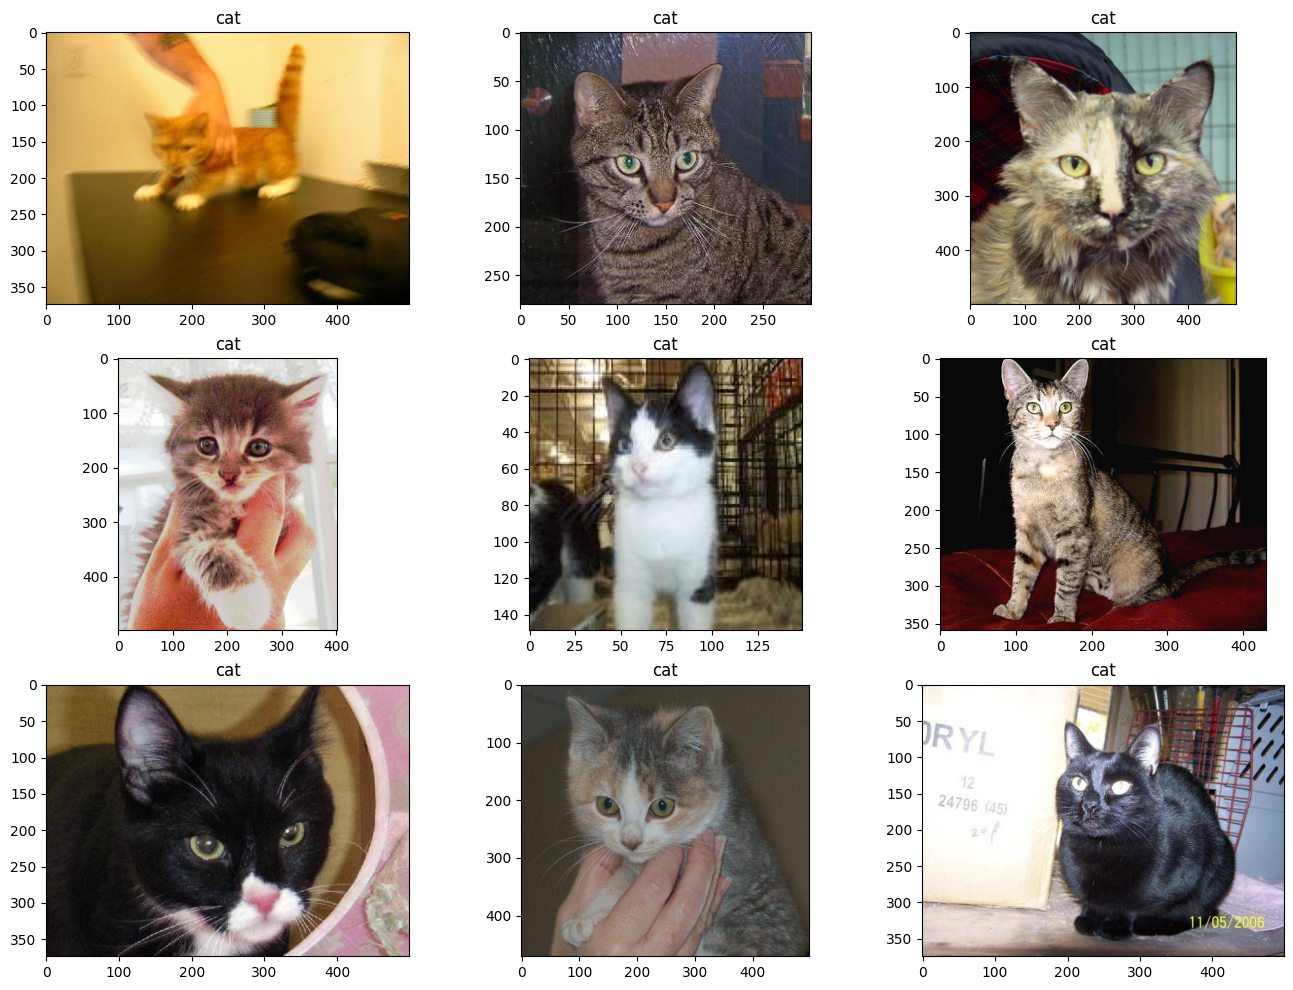

In [23]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

## Split

In [24]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [25]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augmentation

In [26]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(sizes),
        transforms.GaussianBlur(kernel_size=(11,11), sigma=(0.05, 2)),
        transforms.RandomAffine(0, shear=10,scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
        transforms.RandomResizedCrop(sizes),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225)
        )
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(sizes),
        transforms.CenterCrop(sizes),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225)
        )
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(sizes),
        transforms.CenterCrop(sizes),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [27]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [28]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [29]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True )
test_loader  = DataLoader(dataset = test_data,  batch_size=batch_size, shuffle=True )

In [30]:
print(len(train_data), len(train_loader))
print(len(valid_data), len(valid_loader))

20000 313
5000 79


In [31]:
def train(
    model,
    criterion,
    optimizer,
    scheduler,
    loader,
    metric,
    epochs,
    phase_train = 'train',
    max_grad_clip_norm = 0.5
):
    for epoch in range(int(len(metric)/2), int(len(metric)/2)+epochs):
        for phase in loader:

            epoch_loss = 0
            epoch_accuracy = 0

            if phase == phase_train:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            for data, label in tqdm(loader[phase]):
                data = data.to(device)
                label = label.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == phase_train):
                    with model.knn_memories_context(batch_size = data.size()[0]) as knn_memories:
                        output = model(
                            data,
                            knn_memories = knn_memories
                        )
                        loss = criterion(output, label)
                        if phase == phase_train:
                            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_clip_norm)
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_clip_norm)
                            optimizer.step()

                        acc = (output.argmax(dim=1) == label).float().mean()

                        epoch_accuracy += acc / len(loader[phase])
                        epoch_loss += loss / len(loader[phase])
            print(
                f"Epoch: {epoch+1} Phase: {phase} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}"
            )
            metric.append({
                "epoch": epoch,
                "phase": phase,
                "loss": epoch_loss.item(),
                "accuracy": epoch_accuracy.item()
            })
    return epoch

# Test SPTViT without Memorizing

In [32]:
# model = MemorizingSPTViT(
#     image_size = sizes,                 # Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
#     patch_size = 32,                    # Number of patches. image_size must be divisible by patch_size. The number of patches is:  n = (image_size // patch_size) ** 2 and n must be greater than 16.
#     num_classes = 2,                    # Number of classes to classify.
#     heads = 16,
#     dim = 1024,                         # Last dimension of output tensor after linear transformation nn.Linear(..., dim).
#     dim_head = 32,                      # dimension per attention head
#     depth = 8,                          # number of layers
    
#     #pool = 'cls',
    
#     memorizing_layers = (),             # which layers to have ANN memories
#     max_knn_memories = 512*64,          # maximum ANN memories to keep (once it hits this capacity, it will be reset for now, due to limitations in faiss' ability to remove entries)
#     num_retrieved_memories = 64,        # number of ANN memories to retrieve
#     clear_memories_on_sos_token_id = None, # clear passed in ANN memories automatically for batch indices which contain this specified SOS token id - otherwise, you can also manually iterate through the ANN memories and clear the indices before the next iteration
 
#     xl_memory_layers = None,
#     xl_max_memories = 0,

#     shift_knn_memories_down = 0,
#     shift_xl_memories_down = 0,

#     knn_attn_heads = None,
#     attn_dropout = 0.1,
#     ff_mult = 4,
#     ff_dropout = 0.1,
#     clear_memories_on_eos_token_id = None,
#     knn_memories_directory = DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY,
    
#     knn_memory_multiprocessing = True

# ).to(device)

In [33]:
# model.load_state_dict(torch.load("pretrained-net-without-mem-240.pt"), strict=False)

In [34]:
# # loss function
# criterion = nn.CrossEntropyLoss()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # optimizer = optim.AdamW(model.parameters(), lr=lr)
# # scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=gamma)

In [35]:
# loader={
#     'train':train_loader,
#     'val':valid_loader
# }

# #net_without_mem=[]

In [36]:
with open('net-without-mem-240.pickle', 'rb') as handle:
    net_without_mem = pickle.load(handle)

In [37]:
for _ in range(20):
    epoch=train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loader=loader,
        metric=net_without_mem,
        epochs=epochs,
    )
    torch.save(model.state_dict(), f'pretrained-net-without-mem-{epoch+1}.pt')
    with open(f'net-without-mem-{epoch+1}.pickle', 'wb') as handle:
        pickle.dump(net_without_mem, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open('net-without-mem-240.pickle', 'rb') as handle:
    net_without_mem = pickle.load(handle)

In [39]:
loss_net_without_mem_val, acc_net_without_mem_val = zip(*[(k["loss"], k["accuracy"]) for k in net_without_mem if k["phase"]=='val'])

In [40]:
loss_net_without_mem_train, acc_net_without_mem_train = zip(*[(k["loss"], k["accuracy"]) for k in net_without_mem if k["phase"]=='train'])

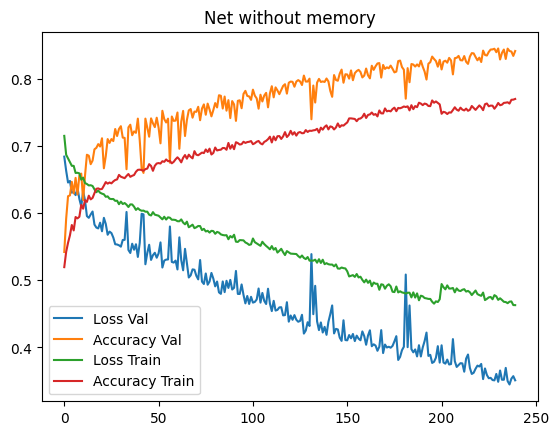

In [41]:
plt.title("Net without memory")

plt.plot(loss_net_without_mem_val, label = "Loss Val")

plt.plot(acc_net_without_mem_val, label = "Accuracy Val")

plt.plot(loss_net_without_mem_train, label = "Loss Train")

plt.plot(acc_net_without_mem_train, label = "Accuracy Train")

plt.legend()
plt.show()

# Test SPTViT Finetuning with Memorizing 

In [42]:
model = MemorizingSPTViT(
    image_size = sizes,                 # Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
    patch_size = 32,                    # Number of patches. image_size must be divisible by patch_size. The number of patches is:  n = (image_size // patch_size) ** 2 and n must be greater than 16.
    num_classes = 2,                    # Number of classes to classify.
    heads = 16,
    dim = 1024,                         # Last dimension of output tensor after linear transformation nn.Linear(..., dim).
    dim_head = 32,                      # dimension per attention head
    depth = 8,                          # number of layers
    
    #pool = 'cls',
    
    memorizing_layers = (4, 5),         # which layers to have ANN memories
    max_knn_memories = 512*64,          # maximum ANN memories to keep (once it hits this capacity, it will be reset for now, due to limitations in faiss' ability to remove entries)
    num_retrieved_memories = 64,        # number of ANN memories to retrieve
    clear_memories_on_sos_token_id = None, # clear passed in ANN memories automatically for batch indices which contain this specified SOS token id - otherwise, you can also manually iterate through the ANN memories and clear the indices before the next iteration
    
    xl_memory_layers = None,
    xl_max_memories = 0,

    shift_knn_memories_down = 0,
    shift_xl_memories_down = 0,

    knn_attn_heads = None,
    attn_dropout = 0.1,
    ff_mult = 4,
    ff_dropout = 0.1,
    clear_memories_on_eos_token_id = None,
    knn_memories_directory = DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY,
    
    knn_memory_multiprocessing = True

).to(device)

model

MemorizingSPTViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b h w (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((15360,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=15360, out_features=1024, bias=True)
    )
  )
  (rel_pos_bias): T5RelativePositionBias(
    (relative_attention_bias): Embedding(32, 16)
  )
  (knn_rel_pos_bias): T5RelativePositionBias(
    (relative_attention_bias): Embedding(32, 16)
  )
  (layers): ModuleList(
    (0-2): 3 x ModuleList(
      (0): PreNormResidual(
        (fn): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_q): Linear(in_features=1024, out_features=512, bias=False)
          (to_kv): Linear(in_features=1024, out_features=64, bias=False)
          (to_out): Linear(in_features=512, out_features=1024, bias=True)
        )
        (no

In [43]:
# model.load_state_dict(torch.load("pretrained-net-without-mem-100.pt"), strict=False)
model.load_state_dict(torch.load("pretrained-net-with-mem-155.pt"), strict=False)

<All keys matched successfully>

In [44]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
optimizer = optim.AdamW(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=3, gamma=gamma)

In [45]:
loader={
    'train':train_loader,
    'val':valid_loader
}

In [46]:
# net_with_mem = net_without_mem
with open('net-with-mem-155.pickle', 'rb') as handle:
    net_with_mem = pickle.load(handle)
epochs       = 5

In [47]:
for _ in range(5):
    epoch=train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        loader=loader,
        metric=net_with_mem,
        epochs=epochs,
    )
    torch.save(model.state_dict(), f'pretrained-net-with-mem-{epoch+1}.pt')
    with open(f'net-with-mem-{epoch+1}.pickle', 'wb') as handle:
        pickle.dump(net_with_mem, handle, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 151 Phase: train - loss: 0.4758 - acc: 0.7625


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 151 Phase: val - loss: 0.4309 - acc: 0.8081


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 152 Phase: train - loss: 0.4792 - acc: 0.7592


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 152 Phase: val - loss: 0.4304 - acc: 0.8000


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 153 Phase: train - loss: 0.4755 - acc: 0.7647


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 153 Phase: val - loss: 0.4351 - acc: 0.8018


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 154 Phase: train - loss: 0.4735 - acc: 0.7620


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 154 Phase: val - loss: 0.4743 - acc: 0.7814


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 155 Phase: train - loss: 0.4753 - acc: 0.7632


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 155 Phase: val - loss: 0.4817 - acc: 0.7826


  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
with open('net-with-mem-155.pickle', 'rb') as handle:
    net_with_mem = pickle.load(handle)

In [49]:
loss_net_with_mem_val, acc_net_with_mem_val = zip(*[(k["loss"], k["accuracy"]) for k in net_with_mem if k["phase"]=='val'])
loss_net_with_mem_train, acc_net_with_mem_train = zip(*[(k["loss"], k["accuracy"]) for k in net_with_mem if k["phase"]=='train'])

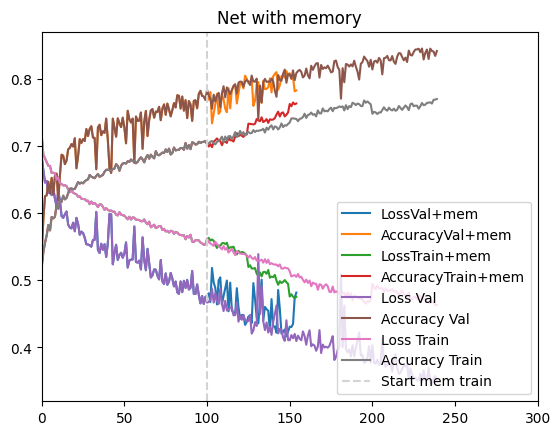

In [50]:
plt.title("Net with memory")

plt.plot(loss_net_with_mem_val, label = "LossVal+mem")

plt.plot(acc_net_with_mem_val, label = "AccuracyVal+mem")

plt.plot(loss_net_with_mem_train, label = "LossTrain+mem")

plt.plot(acc_net_with_mem_train, label = "AccuracyTrain+mem")

# loss_net_without_mem_val

plt.plot(loss_net_without_mem_val, label = "Loss Val")

plt.plot(acc_net_without_mem_val, label = "Accuracy Val")

plt.plot(loss_net_without_mem_train, label = "Loss Train")

plt.plot(acc_net_without_mem_train, label = "Accuracy Train")

plt.axvline(x = 100, color = 'lightgray', linestyle="dashed", label = 'Start mem train')

plt.legend(loc="lower right", ncol=1)

#plt.ylim(0, 1)
plt.xlim(0, 300)

plt.show()

In [51]:
model.knn_memories

AttributeError: 'MemorizingSPTViT' object has no attribute 'knn_memories'

# Test SPTViT with Memorizing and XL memory

In [ ]:
# model = MemorizingSPTViT(
#     image_size = sizes,                 # Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
#     patch_size = 32,                    # Number of patches. image_size must be divisible by patch_size. The number of patches is:  n = (image_size // patch_size) ** 2 and n must be greater than 16.
#     num_classes = 2,                    # Number of classes to classify.
#     heads = 16,
#     dim = 1024,                         # Last dimension of output tensor after linear transformation nn.Linear(..., dim).
#     dim_head = 32,                      # dimension per attention head
#     depth = 8,                          # number of layers
    
#     #pool = 'cls',
    
#     memorizing_layers = (4, 5),      # which layers to have ANN memories
#     max_knn_memories = 512*64,          # maximum ANN memories to keep (once it hits this capacity, it will be reset for now, due to limitations in faiss' ability to remove entries)
#     num_retrieved_memories = 64,        # number of ANN memories to retrieve
#     clear_memories_on_sos_token_id = None, # clear passed in ANN memories automatically for batch indices which contain this specified SOS token id - otherwise, you can also manually iterate through the ANN memories and clear the indices before the next iteration
    
#     xl_memory_layers = (7, 8),
#     xl_max_memories = 1024,

#     shift_knn_memories_down = 0,
#     shift_xl_memories_down = 0,

#     knn_attn_heads = None,
#     attn_dropout = 0.1,
#     ff_mult = 4,
#     ff_dropout = 0.1,
#     clear_memories_on_eos_token_id = None,
#     knn_memories_directory = DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY,
    
#     knn_memory_multiprocessing = True

# ).to(device)

In [ ]:
# model

### Training

In [ ]:
# # loss function
# criterion = nn.CrossEntropyLoss()
# # optimizer
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # scheduler
# scheduler = StepLR(optimizer, step_size=3, gamma=gamma)

In [ ]:
# loader={
#     'train':train_loader,
#     'val':valid_loader
# }

In [ ]:
# net_with_mem_xl=[]

# for epoch in range(epochs):
#     xl_memories = None
#     for phase in loader:
        
#         epoch_loss = 0
#         epoch_accuracy = 0
        
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode
        
#         for data, label in tqdm(loader[phase]):
#             data = data.to(device)
#             label = label.to(device)
            
#             optimizer.zero_grad()
            
#             if phase != 'train':
#                 xl_memories = None
            
#             with torch.set_grad_enabled(phase == 'train'):
#                 with model.knn_memories_context(batch_size = data.size()[0]) as knn_memories:
#                     output, xl_memories = model(
#                         data,
#                         knn_memories = knn_memories,
#                         xl_memories = xl_memories
#                     )
#                     loss = criterion(output, label)
#                     loss = criterion(output, label)
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                     acc = (output.argmax(dim=1) == label).float().mean()

#                     epoch_accuracy += acc / len(loader[phase])
#                     epoch_loss += loss / len(loader[phase])
#         print(
#             f"Epoch: {epoch+1} Phase: {phase} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}"
#         )
#         net_with_mem_xl.append({
#             "epoch": epoch,
#             "phase": phase,
#             "loss": epoch_loss,
#             "accuracy": epoch_accuracy
#         })

In [ ]:
# torch.save(model.state_dict(), 'pretrained-net-with-mem-xl.pt')